# Machine Learning Models implementation

## Imports

In [ ]:
import csv
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
from preprocessing import build_sender_features, preprocess_mail_content

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
csv.field_size_limit(10**7)

131072

## Preprocessing

Load dataset

In [ ]:
initial_df = pd.read_csv("../data/SpamAssasin.csv", encoding="utf-8", engine='python')
df = initial_df.copy()

df.head()

,sender,receiver,date,subject,body,label,urls
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0,1
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...","Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,1
2,"""Tim Chapman"" <timc@2ubh.com>",zzzzteana <zzzzteana@yahoogroups.com>,"Thu, 22 Aug 2002 13:52:38 +0100",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0,1
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient: ;,"Thu, 22 Aug 2002 09:15:25 -0400",[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0,1
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,"Thu, 22 Aug 2002 14:38:22 +0100",Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0,1


Missing values

In [6]:
df.isnull().sum()

sender        0
receiver    210
date          0
subject      16
body          1
label         0
urls          0
dtype: int64

Create new features from sender column

In [7]:
df = build_sender_features(df)
df.head()

,sender,receiver,date,subject,body,label,urls,sender_category,is_mail_only,is_mail_paren_name,...,email_local_len,email_domain_len,email_local_entropy,email_local_has_digits,email_local_has_underscore,email_local_has_dot,email_local_has_plus,email_domain_is_free,email_domain_has_digit,email_domain_has_dash
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0,1,lastname_firstname_angle,0,0,...,3,13,1.584963,0,0,0,0,0,0,0
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...","Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,1,lastname_firstname_angle,0,0,...,10,17,2.921928,0,1,0,0,0,0,1
2,"""Tim Chapman"" <timc@2ubh.com>",zzzzteana <zzzzteana@yahoogroups.com>,"Thu, 22 Aug 2002 13:52:38 +0100",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0,1,quoted_lastname_firstname_angle,0,0,...,4,8,2.000000,0,0,0,0,0,1,0
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient: ;,"Thu, 22 Aug 2002 09:15:25 -0400",[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0,1,lastname_firstname_angle,0,0,...,5,10,2.321928,0,0,0,0,0,0,0
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,"Thu, 22 Aug 2002 14:38:22 +0100",Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0,1,lastname_firstname_angle,0,0,...,13,11,3.180833,0,0,1,0,0,0,0


Check for uncategorized senders

In [8]:
# Check uncategorized senders
uncat_senders = df.loc[df["sender_category"] == "other", "sender"]
print(f"Number of uncategorized senders: {len(uncat_senders)}")

Number of uncategorized senders: 0


Replace the sender_category by a numeric label

In [9]:
le = LabelEncoder()
df["sender_category"] = le.fit_transform(df["sender_category"])

Preprocess the mail subject and body

In [10]:
df["subject"] = df["subject"].apply(preprocess_mail_content)
df["body"] = df["body"].apply(preprocess_mail_content)

# Create the text vectorizer for later use in models
vectorizer = ColumnTransformer(
    transformers=[
        ('tfidf_subject', TfidfVectorizer(), 'subject'),
        ('tfidf_body', TfidfVectorizer(), 'body')
    ],
)

Drop unnecessary columns

In [11]:
df = df.drop(columns=["sender", "receiver", "date"])

## Models Training

### Models' parameters tuning

Create the train and test sets

In [12]:
X = df.drop(columns=["label"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(4647, 29) (1162, 29)
(4647,) (1162,)


Grid Search

In [16]:
param_grid = {
    "LogReg": (
        LogisticRegression(max_iter=1000, n_jobs=None, random_state=42),
        {
            "C": [0.5, 1.0, 2.0],
            "class_weight": [None, "balanced"],
            "penalty": ["l2"],
            "solver": ["lbfgs"]
        }
    ),
    "LinearSVC": (
        LinearSVC(random_state=42),
        {
            "C": [0.5, 1.0, 2.0],
            "class_weight": [None, "balanced"]
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            "n_estimators": [200, 400],
            "max_depth": [None, 20],
            "min_samples_split": [2, 5]
        }
    ),
    "XGBoost": (
        XGBClassifier(random_state=42),
        {
            "n_estimators": [200, 400],
            "max_depth": [3, 6],
            "learning_rate": [0.05, 0.1]
        }
    ),
}

def _build_model_pipeline(model) -> Pipeline:
    return Pipeline(steps=[
        ('vectorizer', vectorizer), # Text vectorization
        ('classifier', model) # Classifier
    ])

for model_name, (model, params) in param_grid.items():
    print(f"Starting Grid Search for {model_name}...")
    pipeline = _build_model_pipeline(model)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid={f"classifier__{key}": value for key, value in params.items()},
        scoring="recall",
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation recall for {model_name}: {grid_search.best_score_:.4f}\n")

Starting Grid Search for LogReg...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for LogReg: {'classifier__C': 2.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best cross-validation recall for LogReg: 0.9607

Starting Grid Search for LinearSVC...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for LinearSVC: {'classifier__C': 0.5, 'classifier__class_weight': 'balanced'}
Best cross-validation recall for LinearSVC: 0.9614

Starting Grid Search for RandomForest...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for RandomForest: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation recall for RandomForest: 0.9345

Starting Grid Search for XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifie

### Best Models Evaluation

Metrics computation function

In [21]:
def _compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_pred)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc
    }

#### Logistic Regression

In [32]:
model = LogisticRegression(
    penalty='l2',
    C=2.0,
    class_weight='balanced',
    solver="lbfgs",
    max_iter=1000,
    n_jobs=None,
    random_state=42
)

pipeline = _build_model_pipeline(model)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

results = _compute_metrics(y_test, y_pred)

for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

accuracy: 0.9802
precision: 0.9679
recall: 0.9651
f1_score: 0.9665
roc_auc: 0.9758


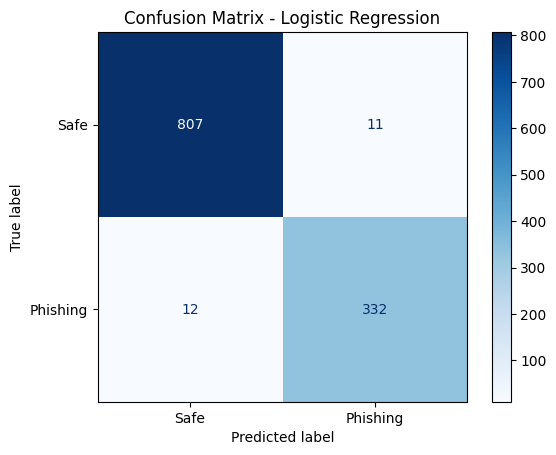

In [36]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe", "Phishing"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

#### Linear SVC

In [39]:
model = LinearSVC(
    C=0.5,
    class_weight='balanced',
    random_state=42
)

pipeline = _build_model_pipeline(model)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

results = _compute_metrics(y_test, y_pred)

for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

accuracy: 0.9811
precision: 0.9680
recall: 0.9680
f1_score: 0.9680
roc_auc: 0.9773


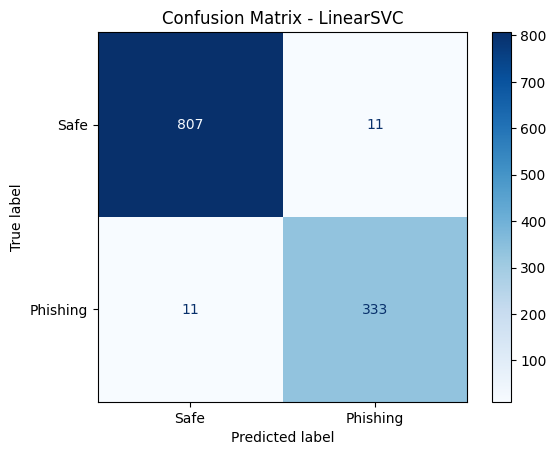

In [40]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe", "Phishing"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - LinearSVC")
plt.show()

#### Random Forest Classifier

In [41]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

pipeline = _build_model_pipeline(model)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

results = _compute_metrics(y_test, y_pred)

for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

accuracy: 0.9759
precision: 0.9702
recall: 0.9477
f1_score: 0.9588
roc_auc: 0.9677


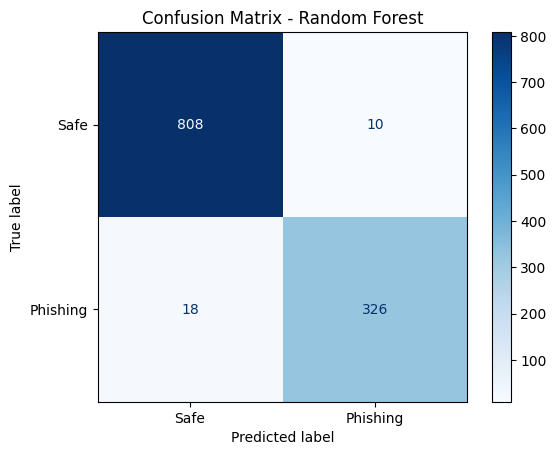

In [42]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe", "Phishing"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Random Forest")
plt.show()

#### XGBoost Classifier

In [43]:
model = XGBClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=400,
    random_state=42
)

pipeline = _build_model_pipeline(model)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

results = _compute_metrics(y_test, y_pred)

for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

accuracy: 0.9707
precision: 0.9641
recall: 0.9360
f1_score: 0.9499
roc_auc: 0.9607


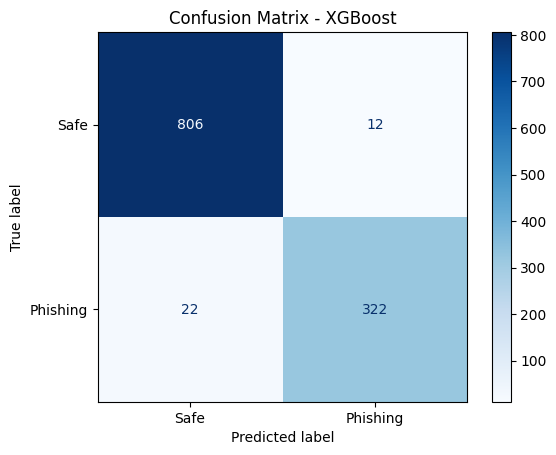

In [44]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe", "Phishing"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - XGBoost")
plt.show()

## Final Results

| Model                 | Accuracy | Precision | Recall | F1-Score | ROC AUC |
|-----------------------|----------|-----------|--------|----------|---------|
| Logistic Regression   | 0.9802   | 0.9679    | 0.9651 | 0.9665   | 0.9758  |
| Linear SVC            | 0.9811   | 0.9680    | 0.9680 | 0.9680   | 0.9773  |
| Random Forest         | 0.9759   | 0.9702    | 0.9477 | 0.9588   | 0.9677  |
| XGBoost Classifier    | 0.9707   | 0.9641    | 0.9360 | 0.9499   | 0.9607  |